# Setup, imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/honours
%ls

/content/drive/MyDrive/honours
all/    feature_extraction.py  prep_functions.py  saturated/
dried/  nonsaturated/          __pycache__/       sheets/


In [3]:
from prep_functions import create_images_list,extract_lp_values,extract_gh_values,plot_predictions,plot_all_validation

In [4]:
from feature_extraction import get_distribution,get_image_contours,get_glcmprops,get_shape_features,get_lbp

In [5]:
import pandas as pd

import cv2
from google.colab.patches import cv2_imshow #colab bug with imshow

import glob

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

# Data preparation

In [6]:
#loading two datasets into respective dataframes
gh_df = pd.read_csv('/content/drive/MyDrive/honours/sheets/GrievesHouse.csv')
lp_df = pd.read_csv('/content/drive/MyDrive/honours/sheets/LowerPilmore.csv')

gh_df.head()

,Sample,Stable aggregates (%)
0,1,65.88
1,2,23.90
2,2,31.86
3,3,89.14
4,4,68.71


In [7]:
# creating lists of images(scaled down) and respective label
gh_path = "/content/drive/MyDrive/honours/all/GrievesHouse/*.*"
lp_path = "/content/drive/MyDrive/honours/all/LowerPilmore/*.*"

gh_images,gh_labels,gh_colour = create_images_list(gh_path,(665,665))
lp_images,lp_labels,lp_colour = create_images_list(lp_path,(665,665))


In [8]:
# CSV file naming differs from file naming - cleaning up:
gh_values = extract_gh_values(gh_labels,gh_df)
lp_values = extract_lp_values(lp_labels,lp_df)


In [9]:
all_values = gh_values + lp_values
scaler = StandardScaler()
all_values = np.array(all_values).reshape(-1, 1) #scaler expectis a 2d array
st_values = scaler.fit_transform(all_values)

In [10]:
from skimage.feature import graycomatrix,graycoprops
from skimage.morphology import disk
from skimage.filters import rank

from google.colab.patches import cv2_imshow #colab bug with imshow


In [11]:
all_images = gh_images + lp_images

feature_vectors = []

for curr_img in all_images:

  curr_contours,curr_perimeters,curr_areas = get_image_contours(curr_img)
  curr_aspects,curr_extents,curr_solidities,curr_diameters = get_shape_features(curr_contours)

  lbp_dist = get_lbp(curr_img,curr_contours)

  perimeter_dist = get_distribution(curr_perimeters,20)
  area_dist = get_distribution(curr_areas,20)
  aspect_dist = get_distribution(curr_aspects,20)
  extent_dist = get_distribution(curr_extents,20)
  solidity_dist = get_distribution(curr_solidities,20)

  vec = lbp_dist.tolist() + perimeter_dist.tolist() + area_dist.tolist() + aspect_dist.tolist() + extent_dist.tolist() + \
    solidity_dist.tolist()

  angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]
  for i in range(4):
    for angle in angles:
      contrast,dissimiliarity,homogeneity,energy,correlation = get_glcmprops(curr_img,curr_contours,i,angle)

      vec += contrast.flatten().tolist() + dissimiliarity.flatten().tolist() + \
      homogeneity.flatten().tolist() + energy.flatten().tolist() + correlation.flatten().tolist()

  feature_vectors.append(vec)






In [12]:
X = feature_vectors
y = st_values

In [13]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [14]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)

In [15]:
from sklearn.metrics import mean_squared_error

# XGBRegressor

## Hyperparameter tuning

In [16]:
max_depth = [1,2]
n_estimators = [100,200,300]
learning_rate = [0.01,0.02,0.04]

In [17]:
rmse_d = {}
for md in max_depth:
  for e in n_estimators:
    for lr in learning_rate:
      all_rmses = []
      for i,(train_idx,test_idx) in enumerate(kf.split(X)):
        X_train = np.take(X, train_idx, axis=0)
        y_train = np.take(y, train_idx, axis=0)

        X_val = np.take(X, test_idx, axis=0)
        y_val = np.take(y, test_idx, axis=0)

        x_scaler = StandardScaler()
        X_train = x_scaler.fit_transform(X_train)
        X_val = x_scaler.transform(X_val)
        xgb_m = XGBRegressor(n_estimators=e, max_depth=md, learning_rate=lr)
        xgb_m.fit(X_train,y_train)
        preds = xgb_m.predict(X_val)
        rmse = mean_squared_error(y_val,preds,squared=False)
        all_rmses.append(rmse)
      rmse_d[(md,e,lr)] = np.average(all_rmses)
      print(md,e,lr,':',rmse_d[(md,e,lr)])



1 100 0.01 : 0.9848822284059772
1 100 0.02 : 0.983770168742619
1 100 0.04 : 0.989407941261718
1 200 0.01 : 0.9834851200825663
1 200 0.02 : 0.9892462015853623
1 200 0.04 : 1.0025430416113115
1 300 0.01 : 0.9850838617173758
1 300 0.02 : 0.996614533767897
1 300 0.04 : 1.0148401237705948
2 100 0.01 : 0.9879257814166514
2 100 0.02 : 0.9898505273182774
2 100 0.04 : 0.9979711523808422
2 200 0.01 : 0.9902489145747605
2 200 0.02 : 0.9970235219768666
2 200 0.04 : 1.0110482074927618
2 300 0.01 : 0.9933349545806855
2 300 0.02 : 1.007377978887836
2 300 0.04 : 1.0227844175962972


In [18]:
dict(sorted(rmse_d.items(), key=lambda item: item[1]))

{(1, 200, 0.01): 0.9834851200825663,
 (1, 100, 0.02): 0.983770168742619,
 (1, 100, 0.01): 0.9848822284059772,
 (1, 300, 0.01): 0.9850838617173758,
 (2, 100, 0.01): 0.9879257814166514,
 (1, 200, 0.02): 0.9892462015853623,
 (1, 100, 0.04): 0.989407941261718,
 (2, 100, 0.02): 0.9898505273182774,
 (2, 200, 0.01): 0.9902489145747605,
 (2, 300, 0.01): 0.9933349545806855,
 (1, 300, 0.02): 0.996614533767897,
 (2, 200, 0.02): 0.9970235219768666,
 (2, 100, 0.04): 0.9979711523808422,
 (1, 200, 0.04): 1.0025430416113115,
 (2, 300, 0.02): 1.007377978887836,
 (2, 200, 0.04): 1.0110482074927618,
 (1, 300, 0.04): 1.0148401237705948,
 (2, 300, 0.04): 1.0227844175962972}

## Best/worst models

------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------


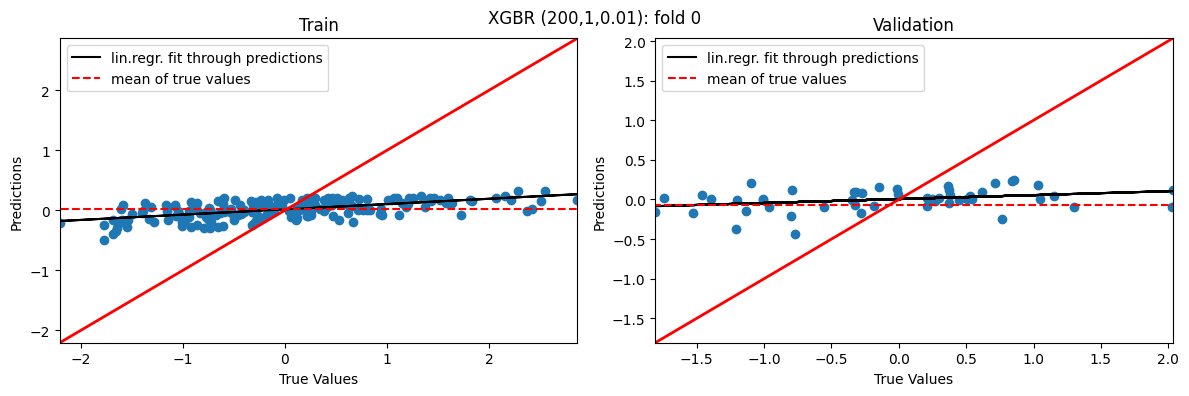

0.9374925713319721
0.883033677364224
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------


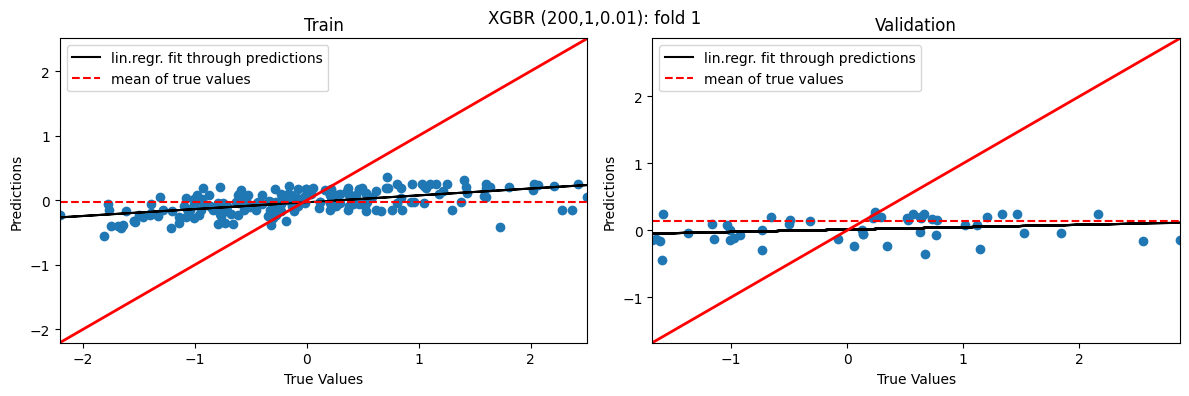

0.8732389679076673
1.102155728550447
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------


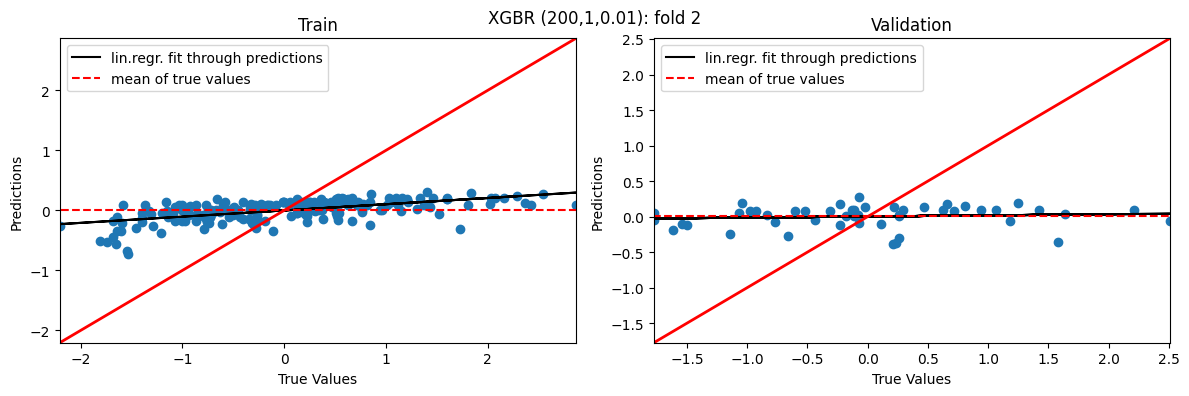

0.9101322586632158
0.9836763235531966
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------


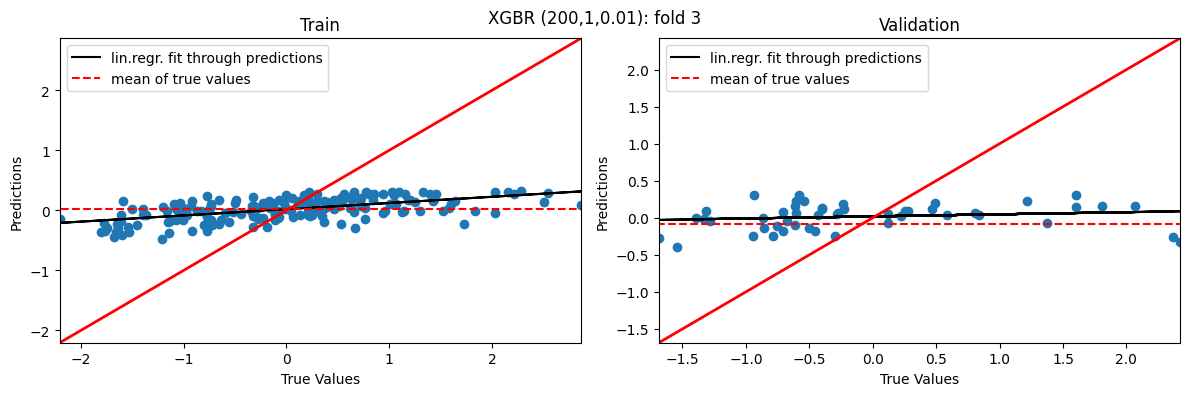

0.9019871379824917
1.012646917001645
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------


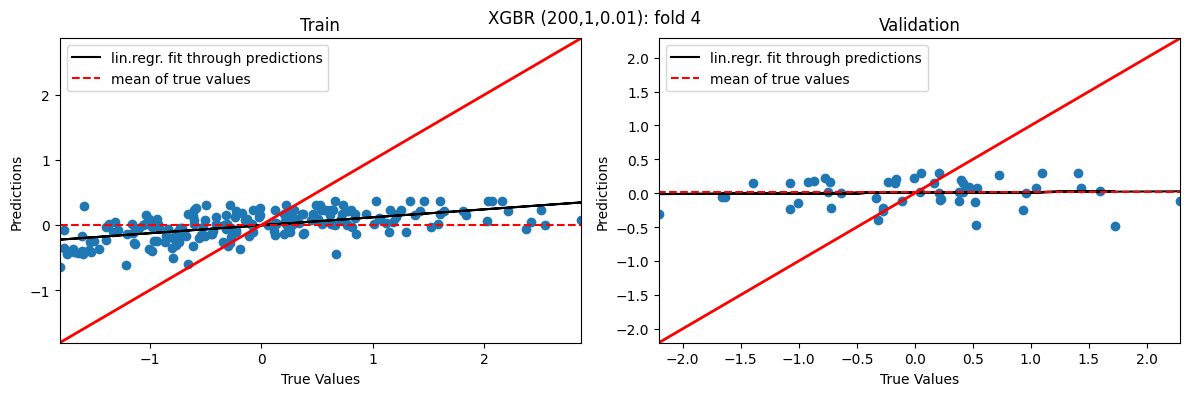

0.9105005194783613
0.9359129539433189
train avg rmse: 0.9066702910727417
validation avg rmse: 0.9834851200825663


In [19]:
train_rmses = []
val_rmses = []
xgb200_1_pred_val = []
xgb200_1_true_val = []
for i,(train_idx,test_idx) in enumerate(kf.split(X)):
  print('-'*66)
  print('-'*30+f'Fold {i}'+'-'*30)
  print('-'*66)

  X_train = np.take(X, train_idx, axis=0)
  y_train = np.take(y, train_idx, axis=0)

  X_val = np.take(X, test_idx, axis=0)
  y_val = np.take(y, test_idx, axis=0)

  x_scaler = StandardScaler()
  X_train = x_scaler.fit_transform(X_train)
  X_val = x_scaler.transform(X_val)

  xgb_model = XGBRegressor(n_estimators=200, max_depth=1, learning_rate=0.01)
  xgb_model.fit(X_train,y_train)
  preds = xgb_model.predict(X_val)
  preds_train = xgb_model.predict(X_train)
  plot_predictions(y_val,preds,y_train,preds_train,f'XGBR (200,1,0.01): fold {i}')
  tr = mean_squared_error(y_train,preds_train,squared=False)
  vr = mean_squared_error(y_val,preds,squared=False)
  train_rmses.append(tr)
  val_rmses.append(vr)
  print(tr)
  print(vr)
  xgb200_1_pred_val.append(preds)
  xgb200_1_true_val.append(y_val)
print(f'train avg rmse: {np.average(train_rmses)}')
print(f'validation avg rmse: {np.average(val_rmses)}')

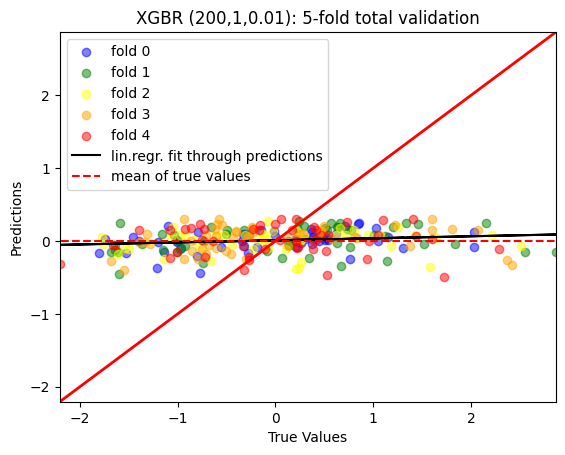

In [20]:
plot_all_validation(xgb200_1_true_val,xgb200_1_pred_val,'XGBR (200,1,0.01): 5-fold total validation')

------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------


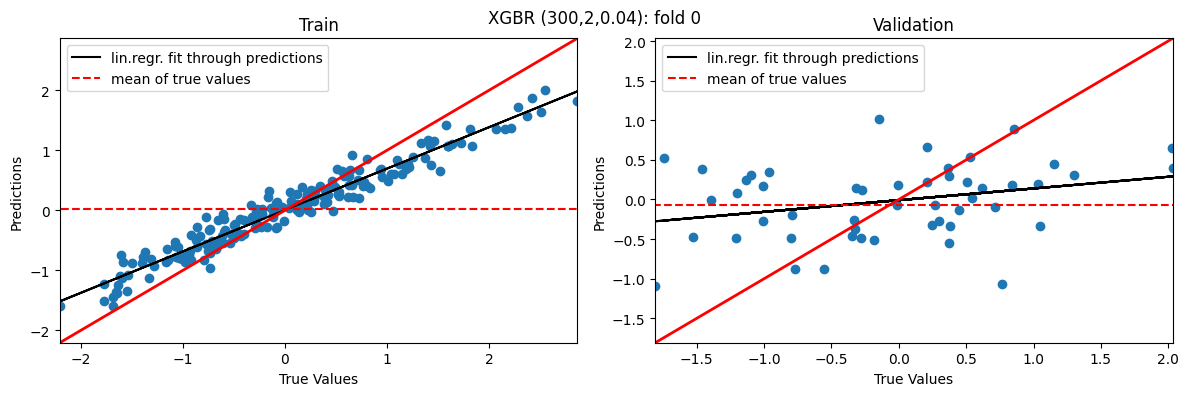

0.35928160545640964
0.9018757043582991
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------


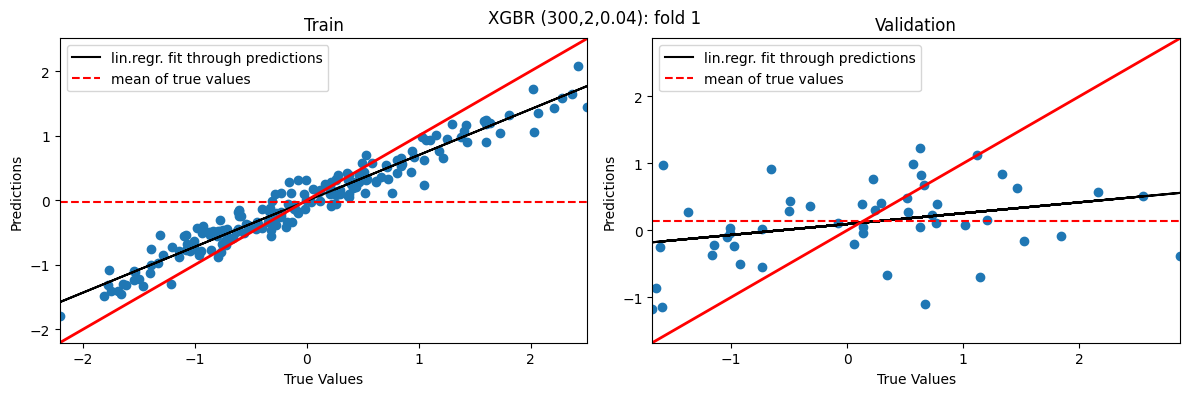

0.32599975995615027
1.0854744608798148
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------


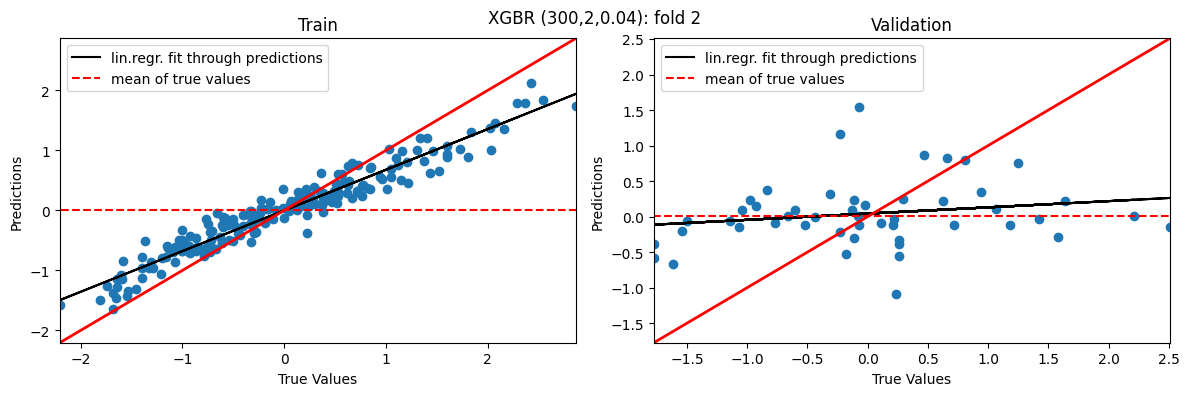

0.37335972241759013
1.0083556271484624
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------


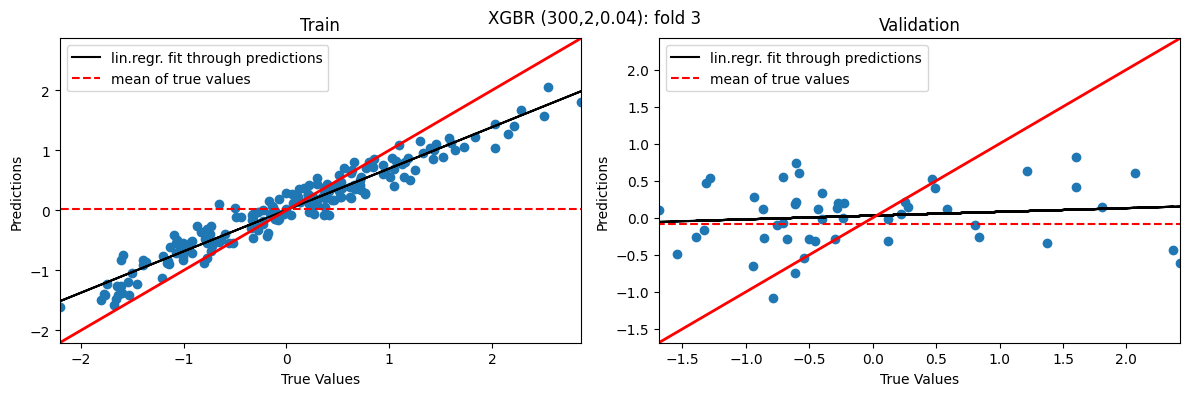

0.3554649276994314
1.059191941436495
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------


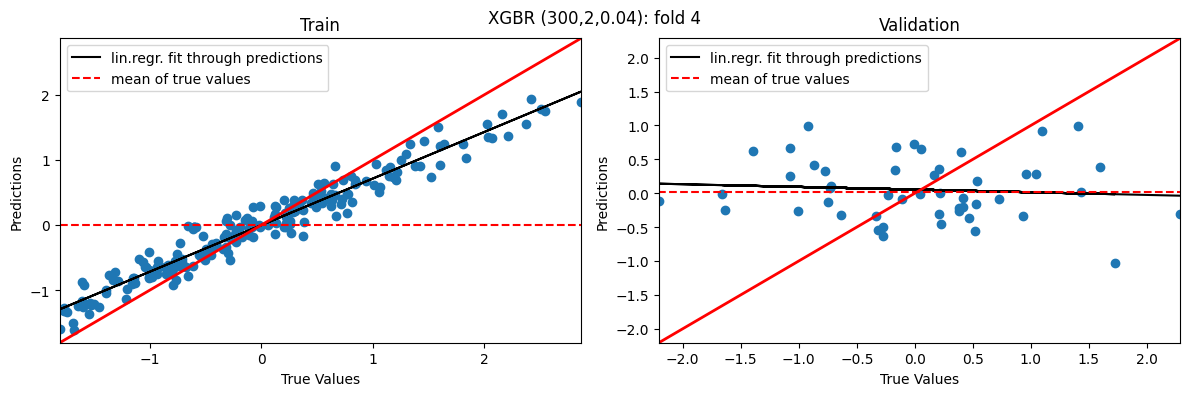

0.3403838405924889
1.0590243541584141
train avg rmse: 0.3508979712244141
validation avg rmse: 1.0227844175962972


In [21]:
train_rmses = []
val_rmses = []
xgb300_2_pred_val = []
xgb300_2_true_val = []

for i,(train_idx,test_idx) in enumerate(kf.split(X)):
  print('-'*66)
  print('-'*30+f'Fold {i}'+'-'*30)
  print('-'*66)

  X_train = np.take(X, train_idx, axis=0)
  y_train = np.take(y, train_idx, axis=0)

  X_val = np.take(X, test_idx, axis=0)
  y_val = np.take(y, test_idx, axis=0)

  x_scaler = StandardScaler()
  X_train = x_scaler.fit_transform(X_train)
  X_val = x_scaler.transform(X_val)

  xgb_model = XGBRegressor(n_estimators=300, max_depth=2, learning_rate=0.04)
  xgb_model.fit(X_train,y_train)
  preds = xgb_model.predict(X_val)
  preds_train = xgb_model.predict(X_train)
  plot_predictions(y_val,preds,y_train,preds_train,f'XGBR (300,2,0.04): fold {i}')
  tr = mean_squared_error(y_train,preds_train,squared=False)
  vr = mean_squared_error(y_val,preds,squared=False)
  train_rmses.append(tr)
  val_rmses.append(vr)
  print(tr)
  print(vr)
  xgb300_2_pred_val.append(preds)
  xgb300_2_true_val.append(y_val)
print(f'train avg rmse: {np.average(train_rmses)}')
print(f'validation avg rmse: {np.average(val_rmses)}')

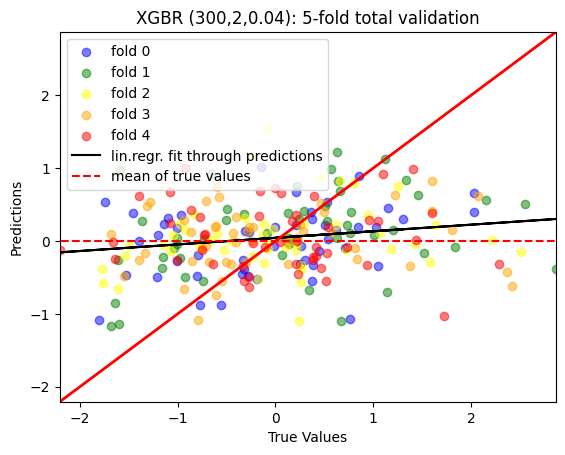

In [22]:
plot_all_validation(xgb300_2_true_val,xgb300_2_pred_val,'XGBR (300,2,0.04): 5-fold total validation')

#RandomForestRegressor

## Hyperparameter tuning

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
rmse_dt = {}
for md in range(1,9,2):
  for e in range(10,200,30):
      all_rmses = []
      for i,(train_idx,test_idx) in enumerate(kf.split(X)):
        X_train = np.take(X, train_idx, axis=0)
        y_train = np.take(y, train_idx, axis=0)

        X_val = np.take(X, test_idx, axis=0)
        y_val = np.take(y, test_idx, axis=0)

        x_scaler = StandardScaler()
        X_train = x_scaler.fit_transform(X_train)
        X_val = x_scaler.transform(X_val)
        rf_m = RandomForestRegressor(max_depth=md,n_estimators=e)
        rf_m.fit(X_train,y_train.ravel())
        preds = rf_m.predict(X_val)
        rmse = mean_squared_error(y_val.ravel(),preds,squared=False)
        all_rmses.append(rmse)
      rmse_dt[(md,e)] = np.average(all_rmses)
      print(md,e,':',rmse_dt[(md,e)])

1 10 : 0.9810770993983944
1 40 : 0.9748867160260296
1 70 : 0.9830423702348463
1 100 : 0.9759674447406747
1 130 : 0.9791503560005719
1 160 : 0.9773573553734061
1 190 : 0.9760628346126621
3 10 : 0.9804747749905787
3 40 : 0.9793379368620835
3 70 : 0.9735590702761365
3 100 : 0.9832652070747814
3 130 : 0.9757195501155973
3 160 : 0.9723997756540179
3 190 : 0.9734392283711486
5 10 : 1.0088592412608972
5 40 : 0.9875044458155278
5 70 : 0.98565604444797
5 100 : 0.9848202135781075
5 130 : 0.9800014479132907
5 160 : 0.9773063189992411
5 190 : 0.9815794942017948
7 10 : 1.0314261237218751
7 40 : 0.9946432825878351
7 70 : 0.9665631482771826
7 100 : 0.9816447382846956
7 130 : 0.9812504812316469
7 160 : 0.9797697511377695
7 190 : 0.9814023358408157


In [25]:
dict(sorted(rmse_dt.items(), key=lambda item: item[1]))

{(7, 70): 0.9665631482771826,
 (3, 160): 0.9723997756540179,
 (3, 190): 0.9734392283711486,
 (3, 70): 0.9735590702761365,
 (1, 40): 0.9748867160260296,
 (3, 130): 0.9757195501155973,
 (1, 100): 0.9759674447406747,
 (1, 190): 0.9760628346126621,
 (5, 160): 0.9773063189992411,
 (1, 160): 0.9773573553734061,
 (1, 130): 0.9791503560005719,
 (3, 40): 0.9793379368620835,
 (7, 160): 0.9797697511377695,
 (5, 130): 0.9800014479132907,
 (3, 10): 0.9804747749905787,
 (1, 10): 0.9810770993983944,
 (7, 130): 0.9812504812316469,
 (7, 190): 0.9814023358408157,
 (5, 190): 0.9815794942017948,
 (7, 100): 0.9816447382846956,
 (1, 70): 0.9830423702348463,
 (3, 100): 0.9832652070747814,
 (5, 100): 0.9848202135781075,
 (5, 70): 0.98565604444797,
 (5, 40): 0.9875044458155278,
 (7, 40): 0.9946432825878351,
 (5, 10): 1.0088592412608972,
 (7, 10): 1.0314261237218751}

## Best/worst models

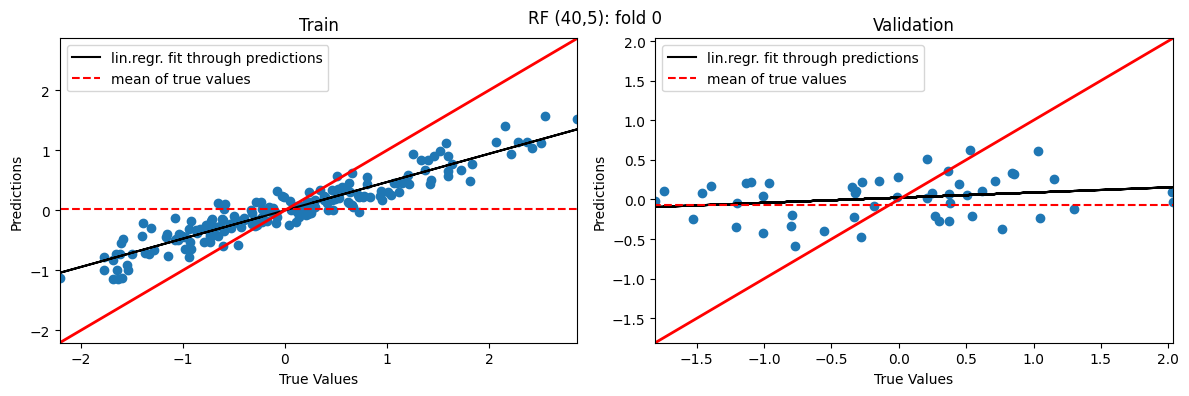

0.5654350151515054
0.9004530268385558


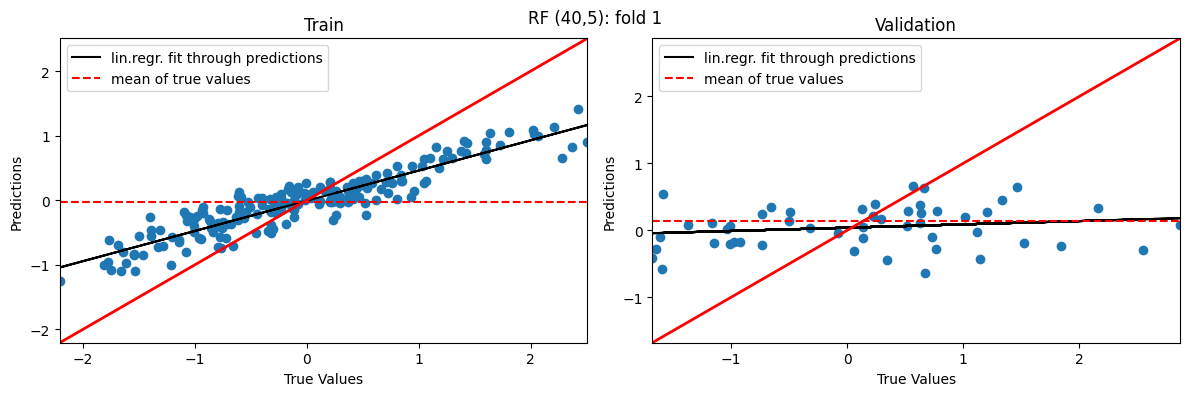

0.5456869463142795
1.1132050813226342


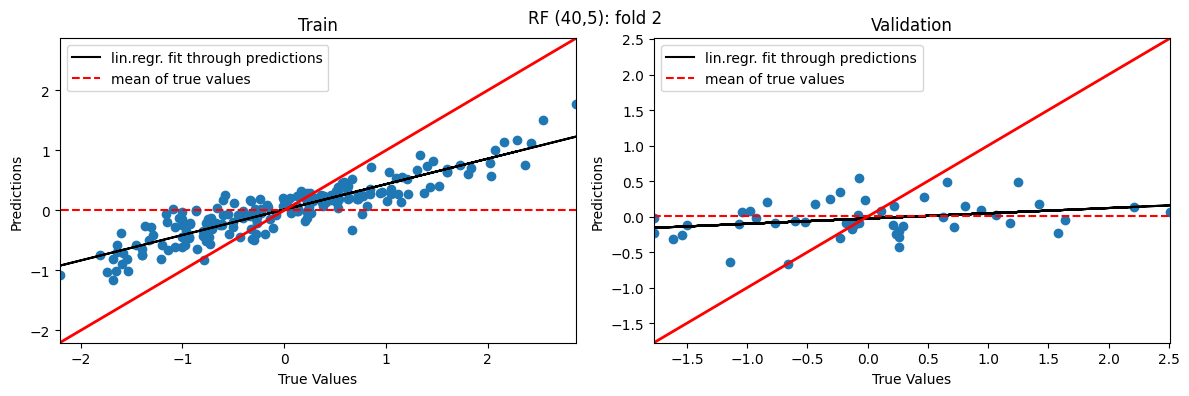

0.6115693653987719
0.9449273788169464


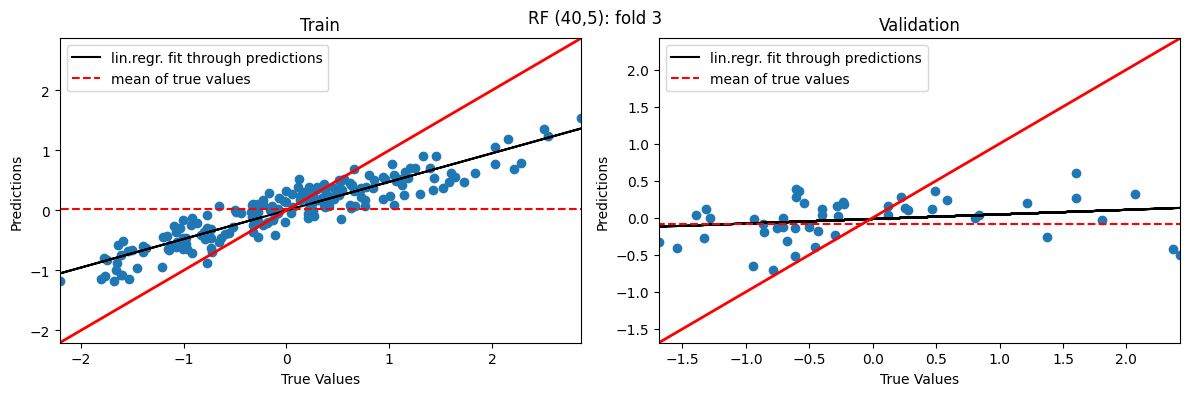

0.5562432028752585
1.0002605144877794


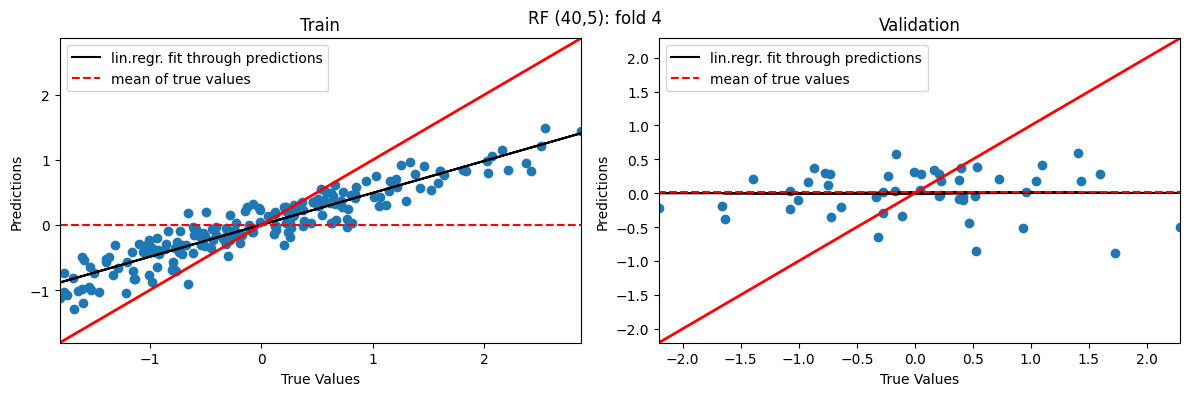

0.5541420763161525
0.9822151944285485
train avg rmse: 0.5666153212111936
validation avg rmse: 0.9882122391788929


In [26]:
train_rmses = []
val_rmses = []
rf40_5_pred_val = []
rf40_5_true_val = []
for i,(train_idx,test_idx) in enumerate(kf.split(X)):
    X_train = np.take(X, train_idx, axis=0)
    y_train = np.take(y, train_idx, axis=0)

    X_val = np.take(X, test_idx, axis=0)
    y_val = np.take(y, test_idx, axis=0)

    x_scaler = StandardScaler()
    X_train = x_scaler.fit_transform(X_train)
    X_val = x_scaler.transform(X_val)
    rf_m = RandomForestRegressor(max_depth=5,n_estimators=40)
    rf_m.fit(X_train,y_train.ravel())

    preds = rf_m.predict(X_val)
    preds_train = rf_m.predict(X_train)
    plot_predictions(y_val,preds,y_train,preds_train,f'RF (40,5): fold {i}')
    tr = mean_squared_error(y_train,preds_train,squared=False)
    vr = mean_squared_error(y_val,preds,squared=False)
    train_rmses.append(tr)
    val_rmses.append(vr)
    print(tr)
    print(vr)
    rf40_5_pred_val.append(preds)
    rf40_5_true_val.append(y_val)
print(f'train avg rmse: {np.average(train_rmses)}')
print(f'validation avg rmse: {np.average(val_rmses)}')


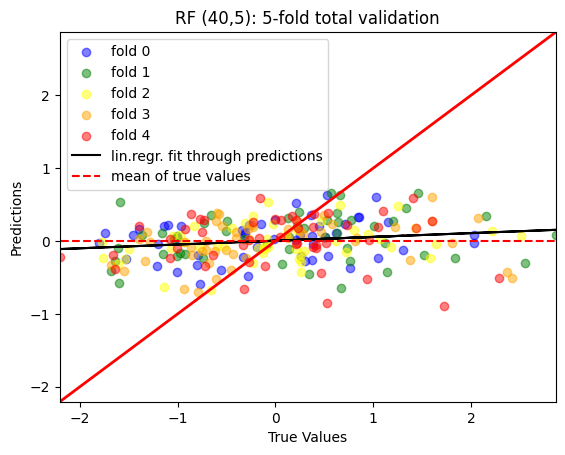

In [27]:
plot_all_validation(rf40_5_true_val,rf40_5_pred_val,'RF (40,5): 5-fold total validation')

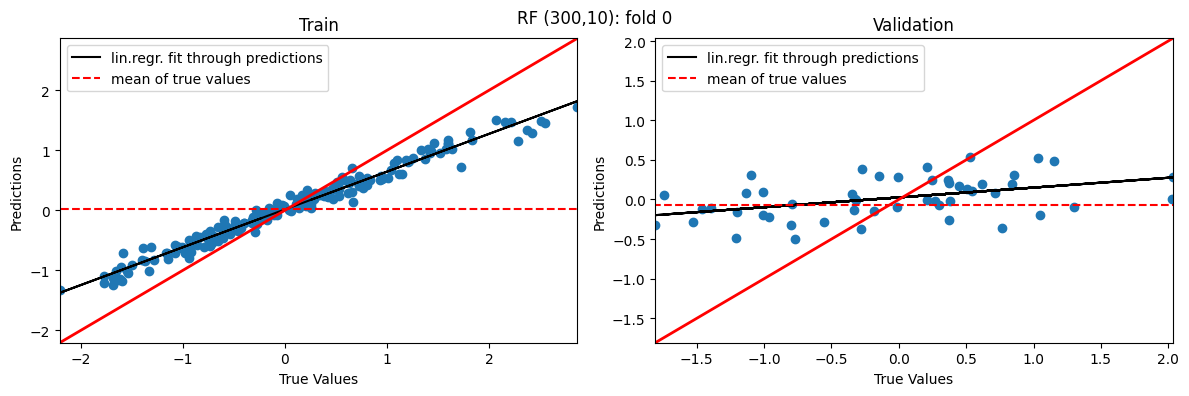

0.3915524464810667
0.8387918634732197


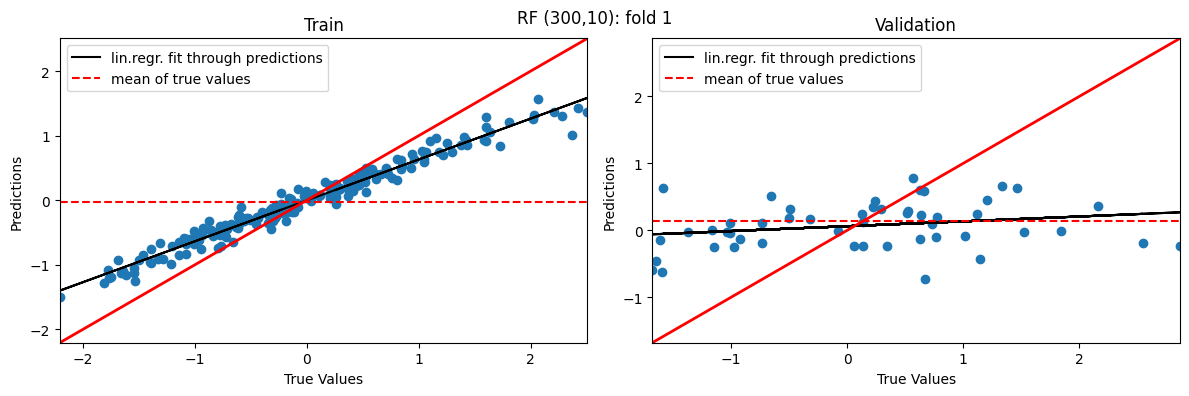

0.3711735946159058
1.095627945341832


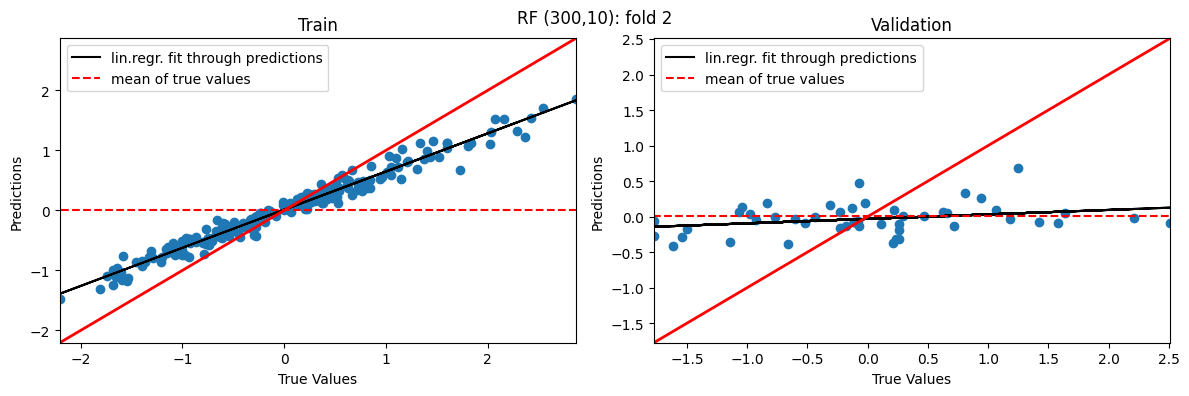

0.3829303152346304
0.9474983754107695


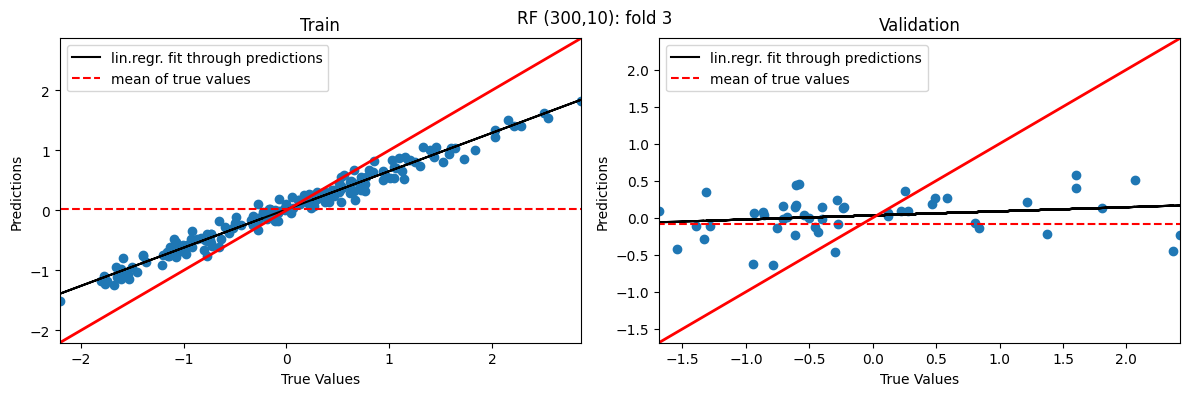

0.3753139185720579
1.0081356893517843


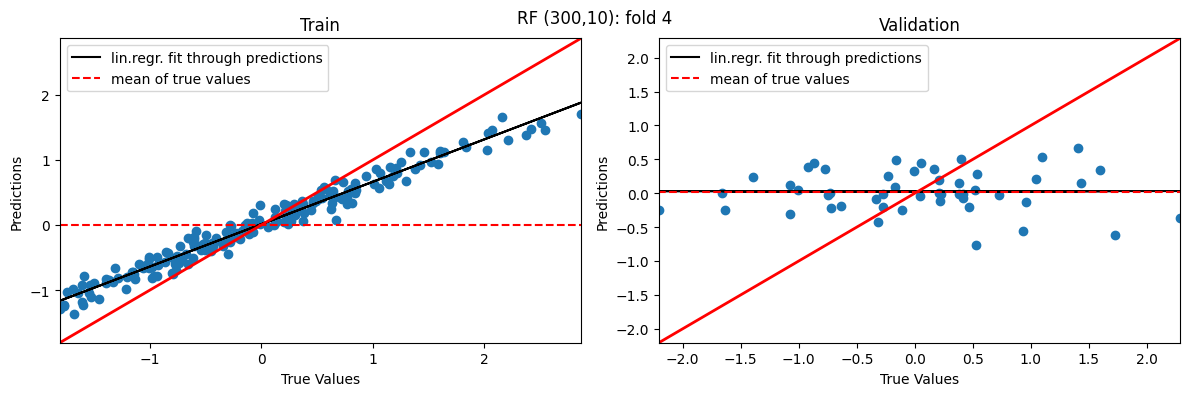

0.37532624307544643
0.9724688578063051
train avg rmse: 0.3792593035958215
validation avg rmse: 0.9725045462767821


In [29]:
train_rmses = []
val_rmses = []
rf300_10_pred_val = []
rf300_10_true_val = []
for i,(train_idx,test_idx) in enumerate(kf.split(X)):
    X_train = np.take(X, train_idx, axis=0)
    y_train = np.take(y, train_idx, axis=0)

    X_val = np.take(X, test_idx, axis=0)
    y_val = np.take(y, test_idx, axis=0)

    x_scaler = StandardScaler()
    X_train = x_scaler.fit_transform(X_train)
    X_val = x_scaler.transform(X_val)
    rf_m = RandomForestRegressor(max_depth=10,n_estimators=300)
    rf_m.fit(X_train,y_train.ravel())

    preds = rf_m.predict(X_val)
    preds_train = rf_m.predict(X_train)
    plot_predictions(y_val,preds,y_train,preds_train,f'RF (300,10): fold {i}')
    tr = mean_squared_error(y_train,preds_train,squared=False)
    vr = mean_squared_error(y_val,preds,squared=False)
    train_rmses.append(tr)
    val_rmses.append(vr)
    print(tr)
    print(vr)

    rf300_10_pred_val.append(preds)
    rf300_10_true_val.append(y_val)
print(f'train avg rmse: {np.average(train_rmses)}')
print(f'validation avg rmse: {np.average(val_rmses)}')



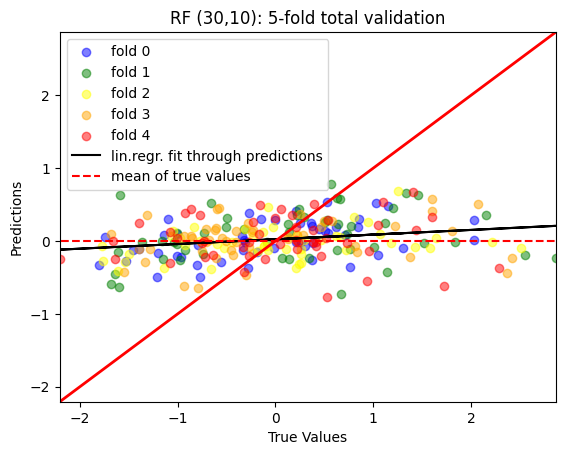

In [30]:
plot_all_validation(rf300_10_true_val,rf300_10_pred_val,'RF (30,10): 5-fold total validation')